В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Area under ROC score on Train dataset: 0.7721%


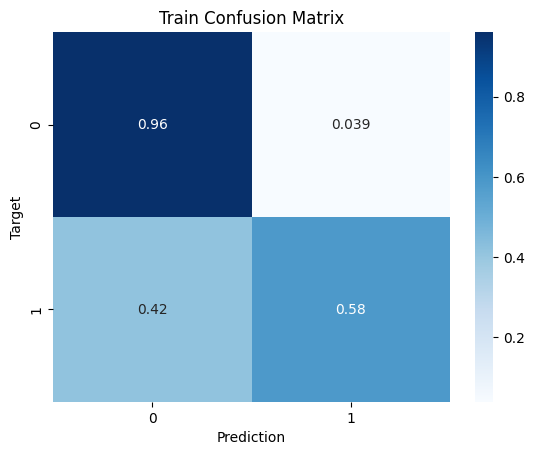

Area under ROC score on Train dataset: 0.7636%


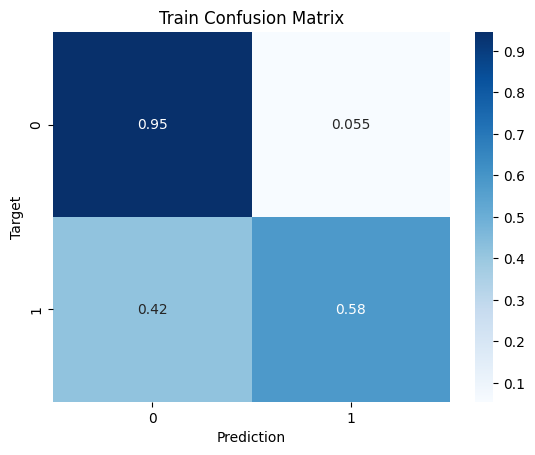

['churn_model_1.joblib']

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

raw_df = pd.read_csv('train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, stratify=raw_df['Exited'], test_size=0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns[:-1].values)
target_col = train_df.columns[-1]
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = list(train_inputs.select_dtypes(['float', 'int']).columns.values)
categorical_cols = list(train_inputs.select_dtypes(['object']).columns.values)

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, thresholds = roc_curve(targets, preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Train')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'churn_model_1.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train with Poly Features dataset: 0.8346%


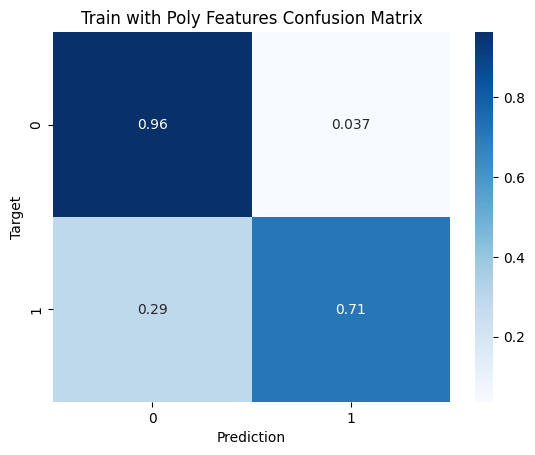

Area under ROC score on Validation with Poly Features dataset: 0.8122%


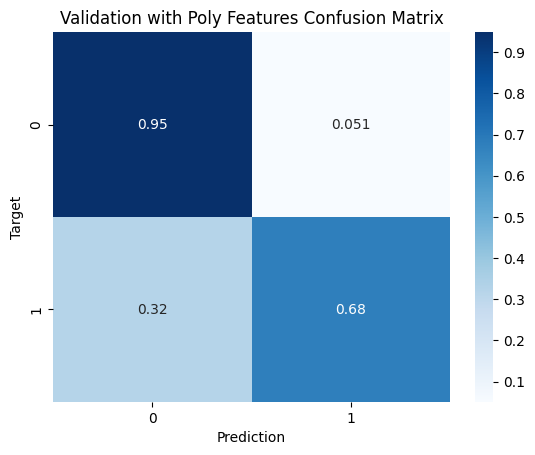

In [8]:
from sklearn.preprocessing import PolynomialFeatures

# Оновлюємо трансформер для числових колонок з додаванням поліноміальних ознак
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо оновлений трансформер з категоріальним
preprocessor_with_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Створюємо новий пайплайн з оновленим препроцесором
model_pipeline_with_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_with_poly),
    ('classifier', LogisticRegression(solver='liblinear'))  
])

# Тренуємо новий пайплайн
model_pipeline_with_poly.fit(train_inputs, train_targets)

# Оцінюємо новий пайплайн на трен і вал наборах
train_preds_poly = predict_and_plot(model_pipeline_with_poly, train_inputs, train_targets, 'Train with Poly Features')
val_preds_poly = predict_and_plot(model_pipeline_with_poly, val_inputs, val_targets, 'Validation with Poly Features')

На мою думку, модель непогана, AUROC для тестувального набору на 2% більша ніж на валідаційному. В даному випадку не спостерігається андерфіт, оскільки показник AUROC 83.4% є досить хорошим. Модель не заоверфітилась, оскільки 2% це допустимий показник для метрики.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train with Poly Features dataset: 0.5794%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


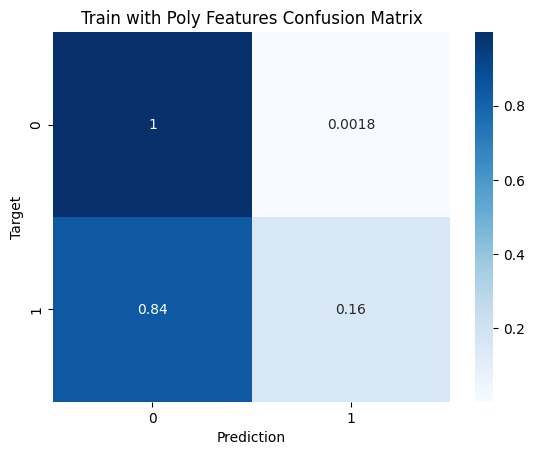

Area under ROC score on Validation with Poly Features dataset: 0.5758%


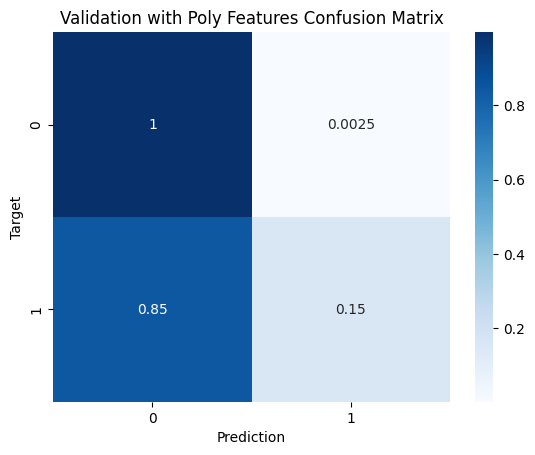

In [9]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer

# Оновлюємо трансформер для числових колонок з додаванням поліноміальних ознак
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=4))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо оновлений трансформер з категоріальним
preprocessor_with_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Створюємо новий пайплайн з оновленим препроцесором
model_pipeline_with_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_with_poly),
    ('classifier', LogisticRegression(solver='liblinear'))  
])

# Тренуємо новий пайплайн
model_pipeline_with_poly.fit(train_inputs, train_targets)

# Оцінюємо новий пайплайн на трен і вал наборах
train_preds_poly = predict_and_plot(model_pipeline_with_poly, train_inputs, train_targets, 'Train with Poly Features')
val_preds_poly = predict_and_plot(model_pipeline_with_poly, val_inputs, val_targets, 'Validation with Poly Features')

Дана модель має гірші показникик AUROC як на тренувальних так і на валідаційних даних. Припускаю, що модель заскладна для вирішення даної задачі, спробуємо поліном 3 степеня

Area under ROC score on Train with Poly Features dataset: 0.8420%


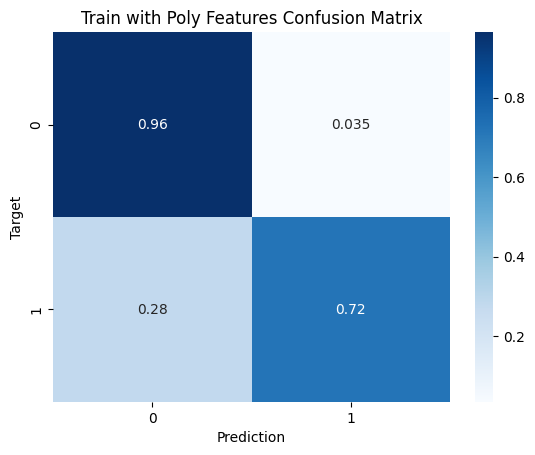

Area under ROC score on Validation with Poly Features dataset: 0.8225%


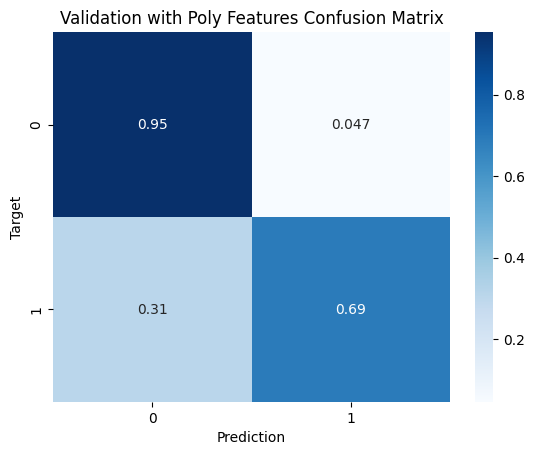

In [10]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer

# Оновлюємо трансформер для числових колонок з додаванням поліноміальних ознак
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо оновлений трансформер з категоріальним
preprocessor_with_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Створюємо новий пайплайн з оновленим препроцесором
model_pipeline_with_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_with_poly),
    ('classifier', LogisticRegression(solver='liblinear'))  
])

# Тренуємо новий пайплайн
model_pipeline_with_poly.fit(train_inputs, train_targets)

# Оцінюємо новий пайплайн на трен і вал наборах
train_preds_poly = predict_and_plot(model_pipeline_with_poly, train_inputs, train_targets, 'Train with Poly Features')
val_preds_poly = predict_and_plot(model_pipeline_with_poly, val_inputs, val_targets, 'Validation with Poly Features')

Отже, найкращий варіант моделі з поліномом 3 степеня.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

regression_data = pd.read_csv('regression_data.csv')

X = regression_data.loc[:, regression_data.columns != 'target']
y = regression_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=5))
])

model_pipeline_regression = Pipeline(steps=[
    ('preprocessor', numerical_transformer),
    ('regressor', LinearRegression())
])

model_pipeline_regression.fit(X_train, y_train)

print("RMSE score for train: {:.4f}".format(root_mean_squared_error(y_train, model_pipeline_regression.predict(X_train))))
print("RMSE score for test: {:.4f}".format(root_mean_squared_error(y_test, model_pipeline_regression.predict(X_test))))

RMSE score for train: 0.0000
RMSE score for test: 16.4078


В даному випадку модель перенавчена, оскільки значення помилки RMSE для train складає 0, тобто модель "ідеальна" для тренувальних даних, проте для тесту, значення помилки складає 16.4. Це показник перенавчання моделі, модель погано генералізує.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [128]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

def train_print_regression_model(model_name):

    numerical_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('poly', PolynomialFeatures(degree=20))
    ])
    
    model_pipeline_regression = Pipeline(steps=[
        ('preprocessor', numerical_transformer),
        ('regressor', model_name)
    ])

    model_pipeline_regression.fit(X_train, y_train)

    print(f"Core metrics for {model_name} model")
    print("RMSE score for train: {:.4f}".format(root_mean_squared_error(y_train, model_pipeline_regression.predict(X_train))))
    print("RMSE score for test: {:.4f}".format(root_mean_squared_error(y_test, model_pipeline_regression.predict(X_test))))
    print(model_pipeline_regression.named_steps['regressor'].coef_)
    print("Count coefs equals to 0: {}".format(model_pipeline_regression.named_steps['regressor'].coef_[model_pipeline_regression.named_steps['regressor'].coef_ == 0].shape))
    print("Count coefs not equals to 0: {}".format(model_pipeline_regression.named_steps['regressor'].coef_[model_pipeline_regression.named_steps['regressor'].coef_ != 0].shape))
    print('\n')

In [129]:
models = [Ridge(), Lasso(), ElasticNet()]

for model in models:
    train_print_regression_model(model)

Core metrics for Ridge() model
RMSE score for train: 5.8851
RMSE score for test: 7.0211
[ 0.         -5.03464351 -3.47010214 ... -0.20229165 -0.18354153
 -0.20846452]
Count coefs equals to 0: (1,)
Count coefs not equals to 0: (53129,)


Core metrics for Lasso() model
RMSE score for train: 5.0982
RMSE score for test: 5.6719
[ 0. -0. -0. ...  0.  0.  0.]
Count coefs equals to 0: (53129,)
Count coefs not equals to 0: (1,)


Core metrics for ElasticNet() model
RMSE score for train: 30.0345
RMSE score for test: 30.4424
[ 0.         -0.02410397 -0.         ...  0.          0.
  0.        ]
Count coefs equals to 0: (52968,)
Count coefs not equals to 0: (162,)




Отже, в результаті, Lasso модель має найкращі показники помилки RMSE, проте аналіз ознак показав, що в моделі присутній лише 1 коефіцієнт, що не дорівнює нулю, тобто Lasso модель занулила багато коефіцієнтів. 
ElasticNet також занулив багато коефіцієнтів, проте показники помилки більші, аніж в Ridge моделі, тому найкраще генералізує модель Ridge.